# IMERG aggregation

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from src.datasources import imerg, zma, ibtracs, codab
from src.utils.raster import upsample_dataarray
from src.constants import *

In [40]:
adm0 = codab.load_codab_from_blob()

<Axes: >

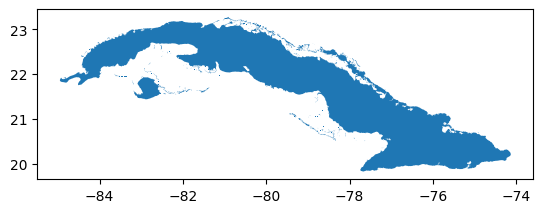

In [41]:
adm0.plot()

In [5]:
gdf_zma = zma.load_zma()

In [7]:
df_all = ibtracs.load_ibtracs_in_bounds(*gdf_zma.total_bounds)

In [8]:
df_all

,point_id,sid,valid_time,latitude,longitude,wind_speed,gust_speed,pressure,max_wind_radius,last_closed_isobar_radius,last_closed_isobar_pressure,basin,nature,provider,quadrant_radius_34,quadrant_radius_50,quadrant_radius_64,created_at
0,acc5b76a-f198-44b1-a07d-d32fb3ea86ad,1852232N21293,1852-08-20 12:00:00.000040,21.700001,-73.000000,70.0,NaN,NaN,NaN,NaN,NaN,NA,TS,hurdat_atl,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",2025-05-13 23:12:11.828324
1,e39ce9ea-4a9d-449d-a4b4-d9e5abbfd4a6,1852232N21293,1852-08-20 18:00:00.000040,21.900000,-74.000000,70.0,NaN,NaN,NaN,NaN,NaN,NA,TS,hurdat_atl,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",2025-05-13 23:12:11.828324
2,92aec772-723f-4e65-be72-f8b61f0945c1,1852232N21293,1852-08-21 00:00:00.000040,22.100000,-74.900002,80.0,NaN,NaN,NaN,NaN,NaN,NA,TS,hurdat_atl,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",2025-05-13 23:12:11.828324
3,662ca6ab-add9-40db-b671-a6fba7a0c399,1852232N21293,1852-08-21 06:00:00.000040,22.200001,-76.099998,80.0,NaN,NaN,NaN,NaN,NaN,NA,TS,hurdat_atl,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",2025-05-13 23:12:11.828324
4,7cf75eac-e87a-4dad-a177-23b34550a0a2,1852232N21293,1852-08-21 12:00:00.000040,22.600000,-77.099998,80.0,NaN,NaN,NaN,NaN,NaN,NA,TS,hurdat_atl,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",2025-05-13 23:12:11.828324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084,50d998ca-2bae-4115-ad2e-a67074e700c1,2024309N13283,2024-11-06 00:00:00.000039,19.400000,-80.000000,70.0,80.0,985.0,15.0,130.0,1006.0,NA,TS,hurdat_atl,"[90.0, 80.0, 20.0, 50.0]","[40.0, 20.0, 0.0, 25.0]","[15.0, 0.0, 0.0, 0.0]",2025-05-13 23:12:11.828324
3085,dc2ee477-be11-40fd-a352-b65772476278,2024309N13283,2024-11-06 06:00:00.000039,20.100000,-80.900002,80.0,90.0,975.0,10.0,110.0,1007.0,NA,TS,hurdat_atl,"[90.0, 80.0, 20.0, 50.0]","[40.0, 20.0, 0.0, 25.0]","[15.0, 0.0, 0.0, 0.0]",2025-05-13 23:12:11.828324
3086,9c06c18c-475c-422f-84da-984bde611551,2024309N13283,2024-11-06 12:00:00.000039,21.000000,-81.599998,90.0,110.0,964.0,10.0,120.0,1008.0,NA,TS,hurdat_atl,"[100.0, 80.0, 40.0, 50.0]","[40.0, 20.0, 20.0, 25.0]","[15.0, 15.0, 10.0, 10.0]",2025-05-13 23:12:11.828324
3087,05611e00-f92e-46c1-a7ef-900f05eb2cf7,2024309N13283,2024-11-06 18:00:00.000039,22.000000,-82.300003,100.0,120.0,955.0,10.0,140.0,1008.0,NA,TS,hurdat_atl,"[100.0, 90.0, 40.0, 50.0]","[50.0, 40.0, 20.0, 25.0]","[25.0, 20.0, 10.0, 15.0]",2025-05-13 23:12:11.828324


In [9]:
df_agg = (
    df_all.groupby("sid")
    .agg(
        valid_time_min=("valid_time", "min"),
        valid_time_max=("valid_time", "max"),
        wind_speed_max=("wind_speed", "max"),
    )
    .reset_index()
)

In [69]:
da_test = imerg.open_imerg_raster_dates(
    pd.date_range("2024-10-20", "2024-10-23")
)

In [70]:
da_test

<xarray.DataArray (date: 4, y: 1800, x: 3600)> Size: 104MB
dask.array<concatenate, shape=(4, 1800, 3600), dtype=float32, chunksize=(1, 1800, 3600), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 29kB -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * y            (y) float64 14kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
    spatial_ref  int64 8B 0
  * date         (date) datetime64[ns] 32B 2024-10-20 2024-10-21 ... 2024-10-23
Attributes: (12/20)
    averaging_period:  daily
    date_issued:       None
    date_valid:        20
    download_date:     2024-10-23
    grid_resolution:   0.1
    leadtime:          None
    ...                ...
    year_valid:        2024
    AREA_OR_POINT:     Area
    _FillValue:        nan
    scale_factor:      1.0
    add_offset:        0.0
    long_name:         precipitation

In [106]:
da_test_clip = da_test.rio.clip(adm0.geometry)

<Axes: title={'center': 'date = 2024-10-21, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

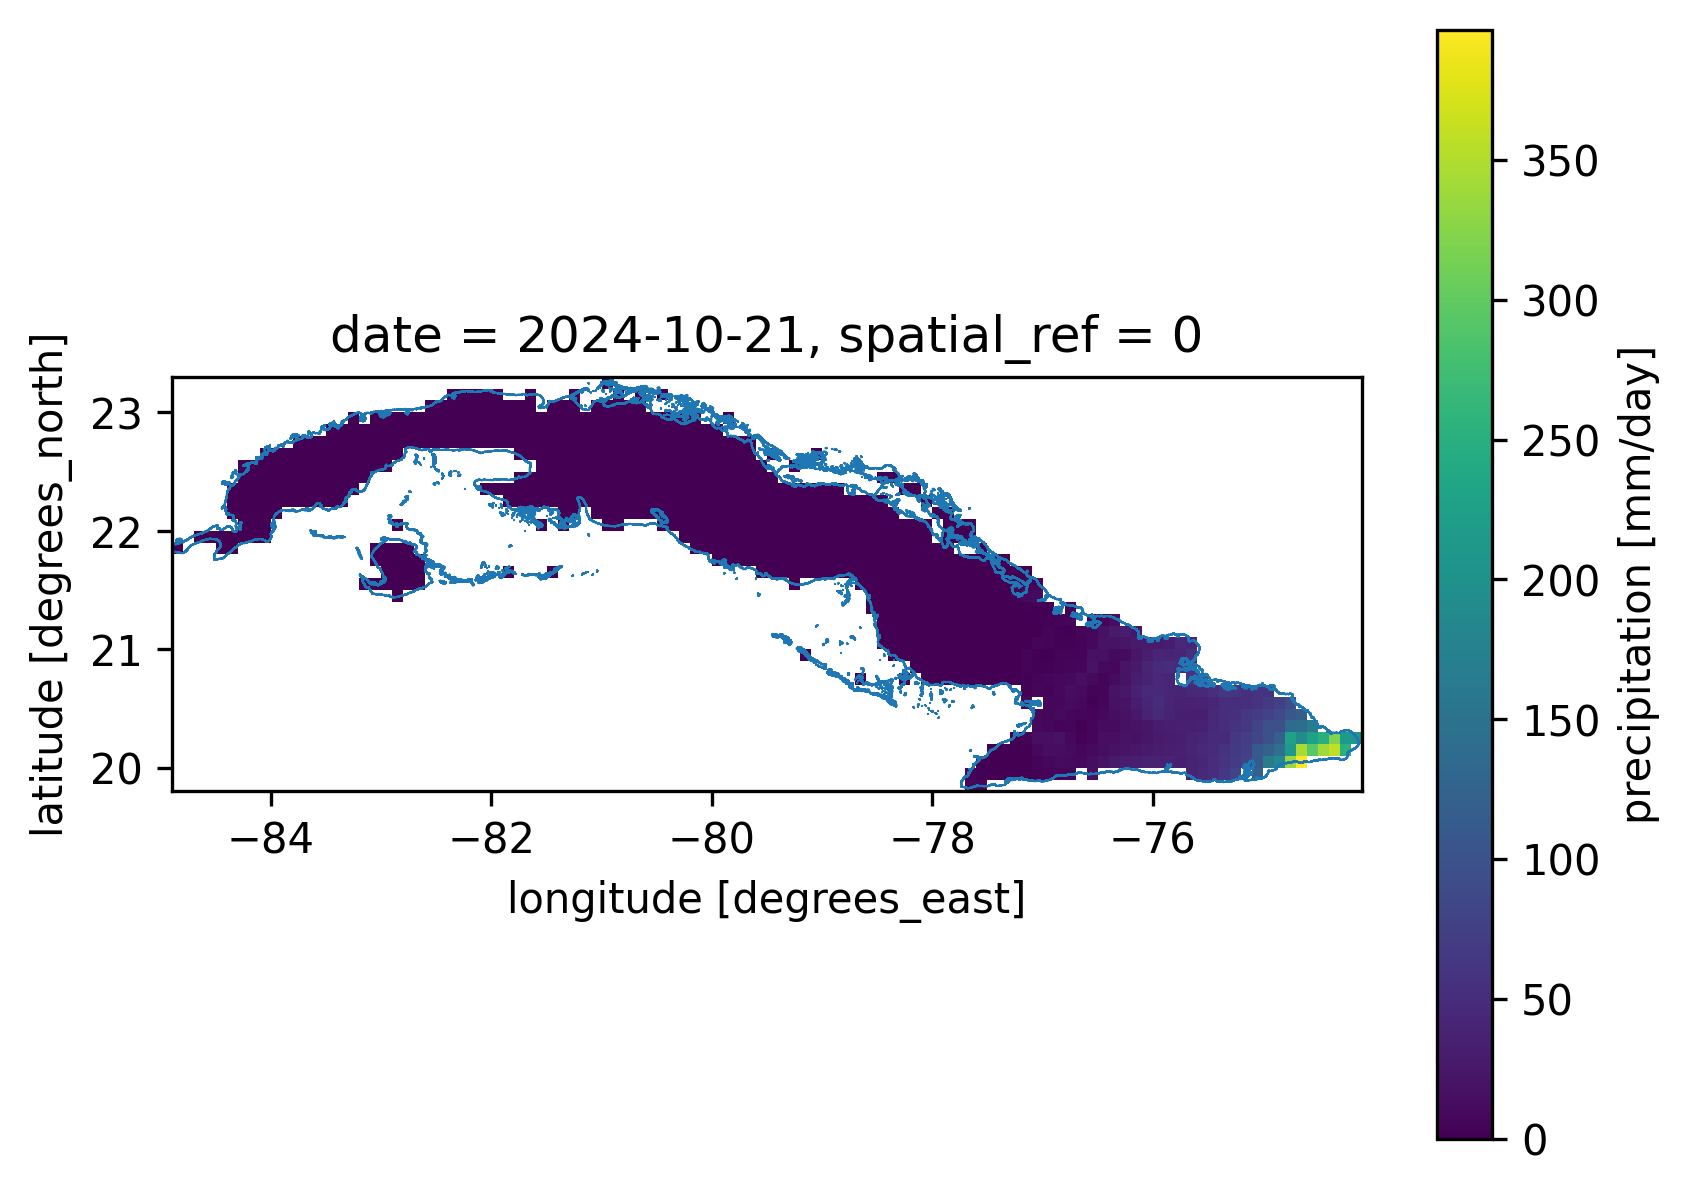

In [108]:
fig, ax = plt.subplots(dpi=300)

da_test_clip.isel(date=1).plot(ax=ax)
adm0.boundary.plot(ax=ax, linewidth=0.5)

<Axes: title={'center': 'date = 2024-10-21, spatial_ref = 0, quantile = 0.9'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

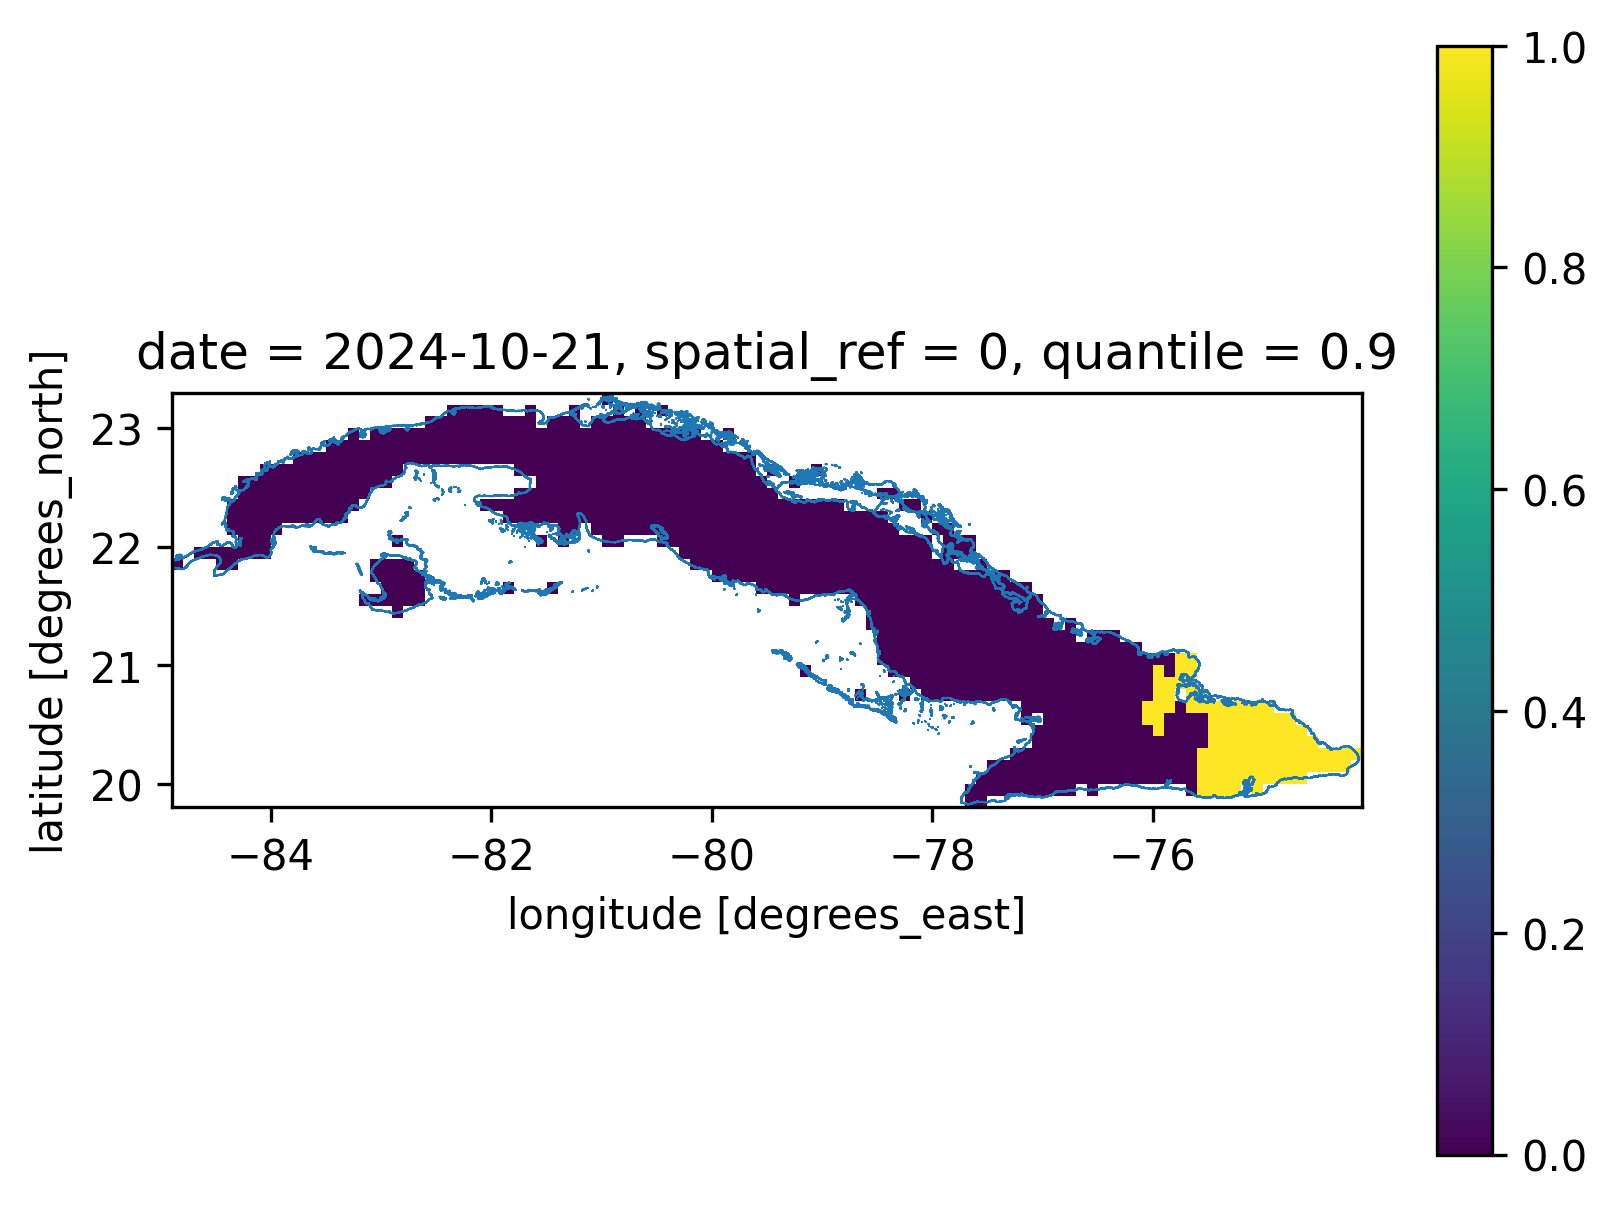

In [110]:
fig, ax = plt.subplots(dpi=300)

(da_test_clip.isel(date=1) > da_test_clip.isel(date=1).quantile(0.9)).where(
    ~da_test_clip.isel(date=1).isnull()
).plot(ax=ax)
adm0.boundary.plot(ax=ax, linewidth=0.5)

<Axes: title={'center': 'date = 2024-10-21, spatial_ref = 0, quantile = ...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

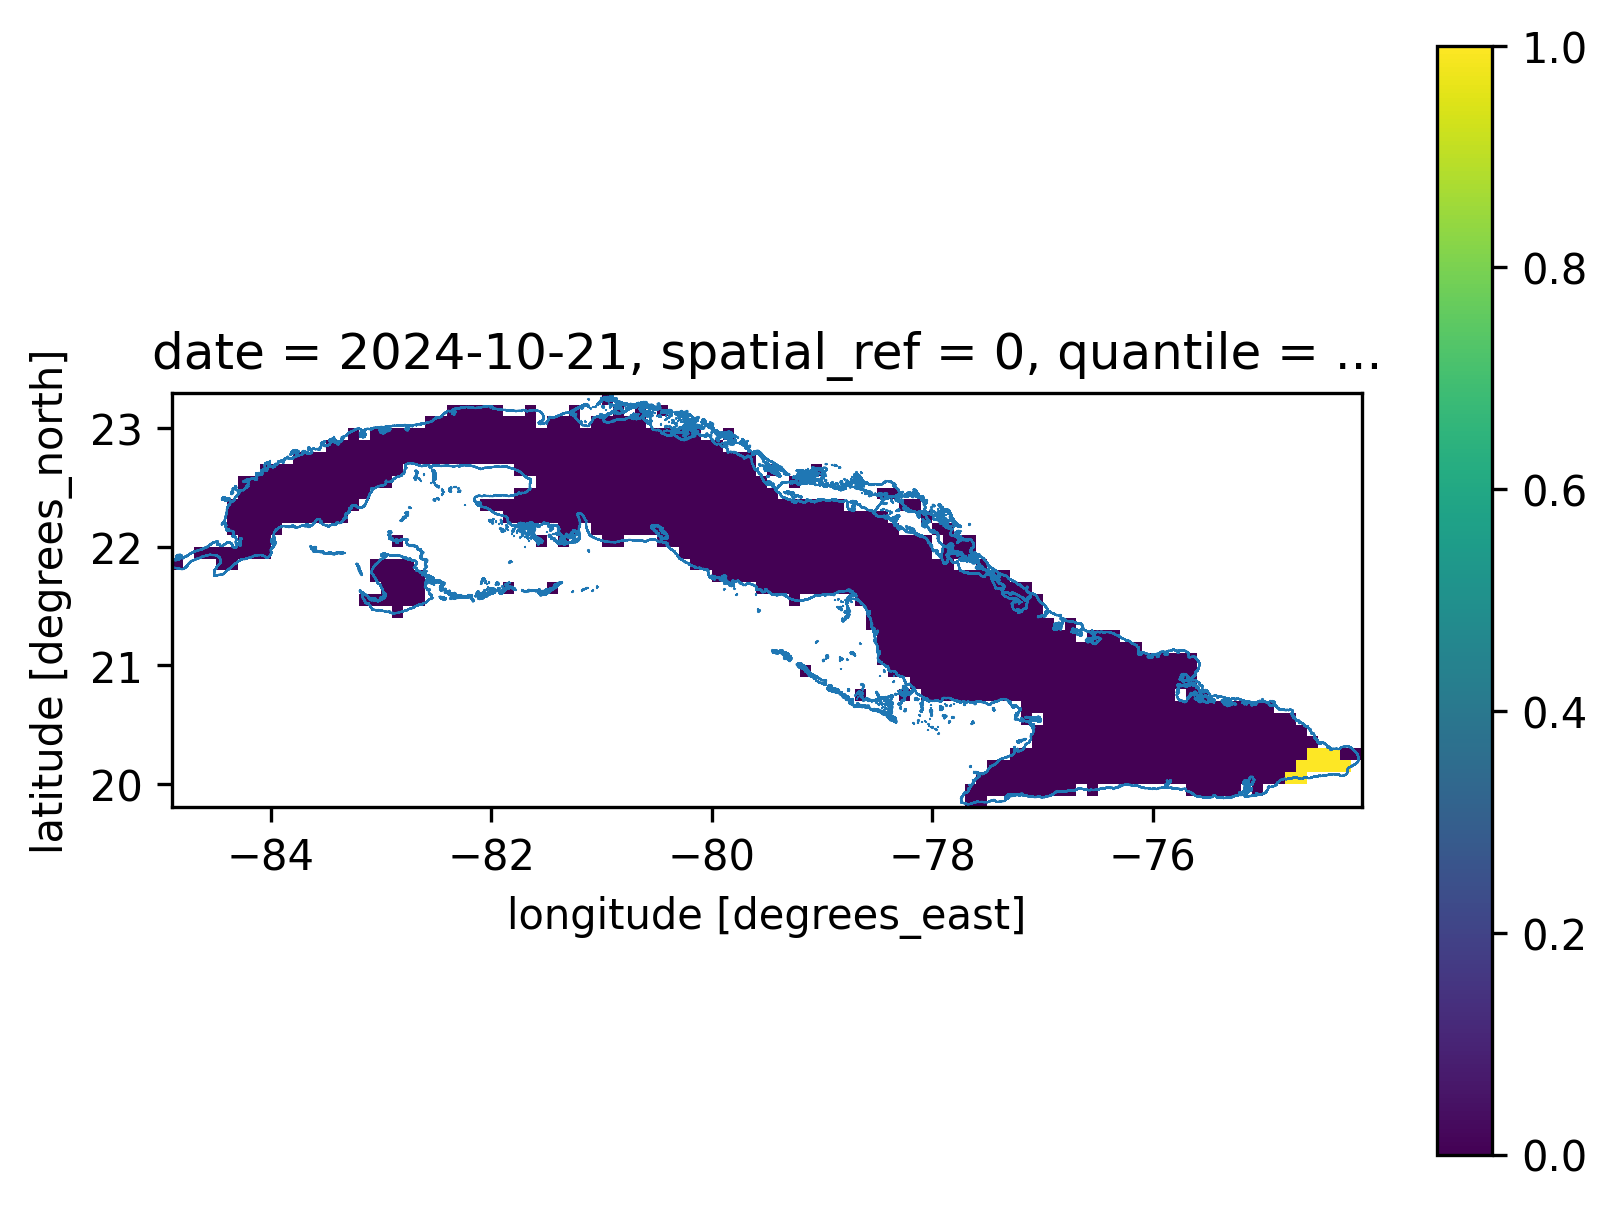

In [111]:
fig, ax = plt.subplots(dpi=300)

(da_test_clip.isel(date=1) > da_test_clip.isel(date=1).quantile(0.99)).where(
    ~da_test_clip.isel(date=1).isnull()
).plot(ax=ax)
adm0.boundary.plot(ax=ax, linewidth=0.5)

In [19]:
df_agg

,sid,valid_time_min,valid_time_max,wind_speed_max
0,1851228N13313,1851-08-19 12:00:00.000040,1851-08-21 12:00:00.000040,70.0
1,1852232N21293,1852-08-20 12:00:00.000040,1852-08-22 12:00:00.000040,90.0
2,1852249N17296,1852-09-06 18:00:00.000040,1852-09-06 18:00:00.000040,40.0
3,1852264N13309,1852-09-27 00:00:00.000040,1852-09-28 00:00:00.000040,80.0
4,1852278N14293,1852-10-07 12:00:00.000040,1852-10-08 06:00:00.000040,90.0
...,...,...,...,...
468,2024216N20284,2024-08-02 12:00:00.000039,2024-08-04 00:00:00.000039,35.0
469,2024268N17278,2024-09-24 06:00:00.000039,2024-09-26 06:00:00.000039,75.0
470,2024279N21265,2024-10-09 02:05:00.000035,2024-10-09 06:00:00.000039,140.0
471,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 12:00:00.000039,75.0


In [21]:
start_date = "2000-06-01"
df_agg_recent = df_agg[df_agg["valid_time_min"] >= start_date]

In [151]:
da_test_clip

<xarray.DataArray (date: 4, y: 35, x: 108)> Size: 60kB
dask.array<getitem, shape=(4, 35, 108), dtype=float32, chunksize=(1, 35, 108), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 864B -84.85 -84.75 -84.65 ... -74.35 -74.25 -74.15
  * y            (y) float64 280B 23.25 23.15 23.05 22.95 ... 20.05 19.95 19.85
  * date         (date) datetime64[ns] 32B 2024-10-20 2024-10-21 ... 2024-10-23
    spatial_ref  int64 8B 0
Attributes: (12/20)
    averaging_period:  daily
    date_issued:       None
    date_valid:        20
    download_date:     2024-10-23
    grid_resolution:   0.1
    leadtime:          None
    ...                ...
    year_valid:        2024
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0
    long_name:         precipitation
    _FillValue:        nan

In [158]:
da_sum_test = da_test_clip.sum(dim="date").where(
    ~da_test_clip.isel(date=0).isnull()
)

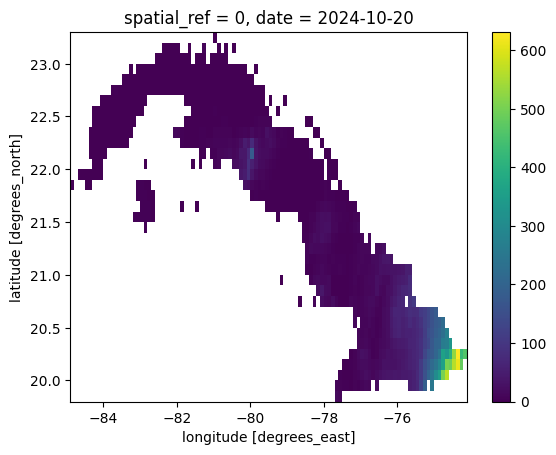

In [159]:
da_sum_test.plot()

In [125]:
da_test_clip

<xarray.DataArray (date: 4, y: 35, x: 108)> Size: 60kB
dask.array<getitem, shape=(4, 35, 108), dtype=float32, chunksize=(1, 35, 108), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 864B -84.85 -84.75 -84.65 ... -74.35 -74.25 -74.15
  * y            (y) float64 280B 23.25 23.15 23.05 22.95 ... 20.05 19.95 19.85
  * date         (date) datetime64[ns] 32B 2024-10-20 2024-10-21 ... 2024-10-23
    spatial_ref  int64 8B 0
Attributes: (12/20)
    averaging_period:  daily
    date_issued:       None
    date_valid:        20
    download_date:     2024-10-23
    grid_resolution:   0.1
    leadtime:          None
    ...                ...
    year_valid:        2024
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0
    long_name:         precipitation
    _FillValue:        nan

In [180]:
da_rolling_test = da_test_clip.rolling(date=1).sum()

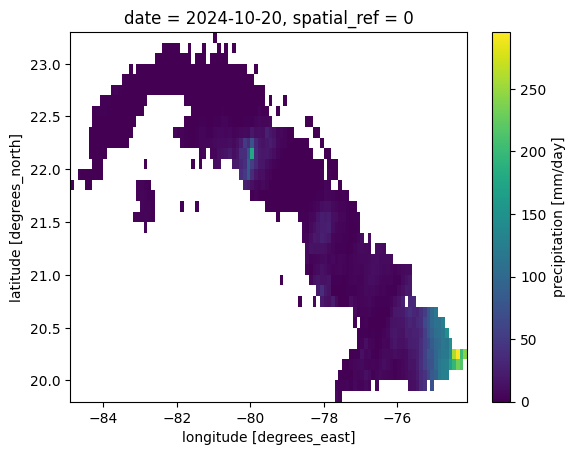

In [181]:
da_rolling_test.isel(date=0).plot()

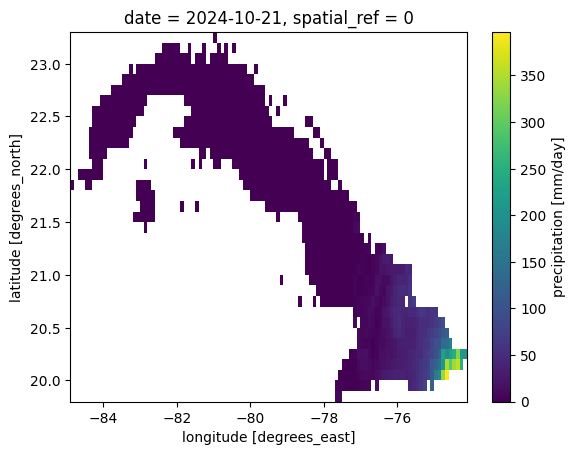

In [182]:
da_rolling_test.isel(date=1).plot()

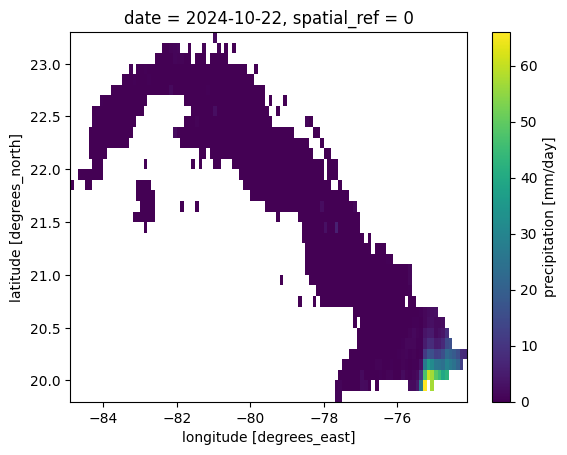

In [183]:
da_rolling_test.isel(date=2).plot()

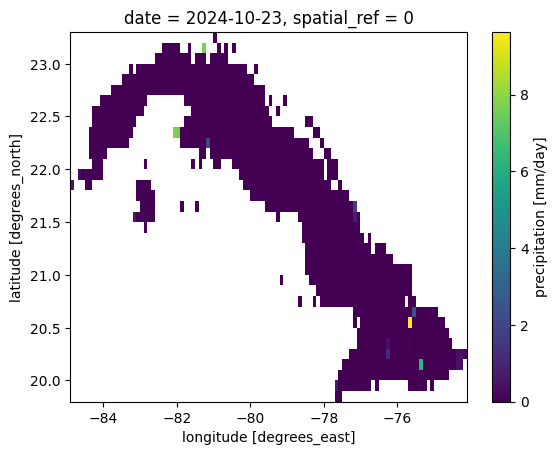

In [184]:
da_rolling_test.isel(date=3).plot()

In [185]:
da_rolling_test

<xarray.DataArray (date: 4, y: 35, x: 108)> Size: 60kB
dask.array<where, shape=(4, 35, 108), dtype=float32, chunksize=(1, 35, 108), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 864B -84.85 -84.75 -84.65 ... -74.35 -74.25 -74.15
  * y            (y) float64 280B 23.25 23.15 23.05 22.95 ... 20.05 19.95 19.85
  * date         (date) datetime64[ns] 32B 2024-10-20 2024-10-21 ... 2024-10-23
    spatial_ref  int64 8B 0
Attributes: (12/20)
    averaging_period:  daily
    date_issued:       None
    date_valid:        20
    download_date:     2024-10-23
    grid_resolution:   0.1
    leadtime:          None
    ...                ...
    year_valid:        2024
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0
    long_name:         precipitation
    _FillValue:        nan

In [186]:
float(da_rolling_test.quantile(0.8, dim=["x", "y"]).max())

11.579999351501469

In [187]:
float(da_sum_test.quantile(0.8, dim=["x", "y"]))

22.595999526977543

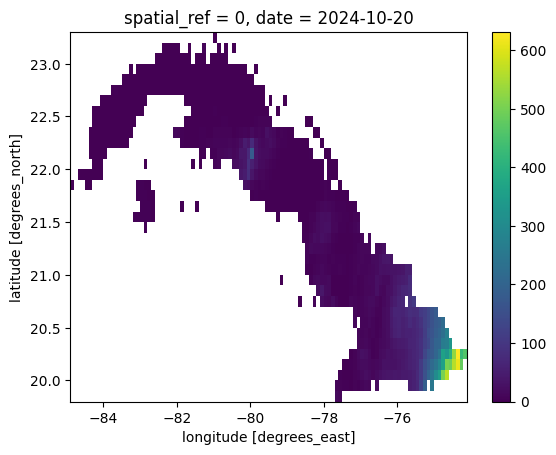

In [163]:
da_sum_test.plot()

In [203]:
quantiles = [0.5, 0.8, 0.9, 0.95, 0.99]


def get_storm_rainfall_aggregations(row):
    row = row.copy()
    min_date = row["valid_time_min"].date() - pd.DateOffset(days=1)
    max_date = row["valid_time_max"].date() + pd.DateOffset(days=1)
    dates = pd.date_range(min_date, max_date)
    da = imerg.open_imerg_raster_dates(dates)
    da_clip = da.rio.clip(adm0.geometry)

    # sum over whole time
    da_sum = da_clip.sum(dim="date").where(~da_clip.isel(date=0).isnull())
    # 2-day rolling sum
    da_rolling2 = da_clip.rolling(date=2).sum()
    # 3-day rolling sum
    da_rolling3 = da_clip.rolling(date=3).sum()

    # take quantiles
    for quantile in quantiles:
        row[f"q{quantile*100:.0f}_total"] = float(
            da_sum.quantile(quantile, dim=["x", "y"])
        )
        row[f"q{quantile*100:.0f}_roll2"] = float(
            da_rolling2.quantile(quantile, dim=["x", "y"]).max()
        )
        row[f"q{quantile*100:.0f}_roll3"] = float(
            da_rolling3.quantile(quantile, dim=["x", "y"]).max()
        )

    return row

In [201]:
q = 0.9
f"q{q*100:.0f}"

'q90'

In [202]:
get_storm_rainfall_aggregations(df_agg_recent.iloc[0])

<xarray.DataArray (date: 3, y: 1800, x: 3600)> Size: 78MB
dask.array<concatenate, shape=(3, 1800, 3600), dtype=float32, chunksize=(1, 1800, 3600), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 29kB -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * y            (y) float64 14kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
    spatial_ref  int64 8B 0
  * date         (date) datetime64[ns] 24B 2000-08-23 2000-08-24 2000-08-25
Attributes: (12/20)
    averaging_period:  daily
    date_issued:       None
    date_valid:        23
    download_date:     2024-09-27
    grid_resolution:   0.1
    leadtime:          None
    ...                ...
    year_valid:        2000
    AREA_OR_POINT:     Area
    _FillValue:        nan
    scale_factor:      1.0
    add_offset:        0.0
    long_name:         precipitation

sid                            2000233N12316
valid_time_min    2000-08-24 00:00:00.000040
valid_time_max    2000-08-24 12:00:00.000040
wind_speed_max                          40.0
q50_total                              18.19
q50_roll2                            18.1525
q50_roll3                          18.189999
q80_total                          35.830003
q80_roll2                          35.588001
q80_roll3                          35.830002
q90_total                          46.248497
q90_roll2                          45.373501
q90_roll3                          46.248497
q95_total                          54.451998
q95_roll2                          53.436249
q95_roll3                             54.452
q99_total                          66.406698
q99_roll2                          66.313896
q99_roll3                            66.4067
Name: 388, dtype: object

In [35]:
tqdm.pandas()

In [204]:
df_agg_recent = df_agg_recent.progress_apply(
    get_storm_rainfall_aggregations, axis=1
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [1:04:45<00:00, 45.71s/it]


In [205]:
df_agg_recent

,sid,valid_time_min,valid_time_max,wind_speed_max,q50_total,q50_roll2,q50_roll3,q80_total,q80_roll2,q80_roll3,q90_total,q90_roll2,q90_roll3,q95_total,q95_roll2,q95_roll3,q99_total,q99_roll2,q99_roll3
388,2000233N12316,2000-08-24 00:00:00.000040,2000-08-24 12:00:00.000040,40.0,18.190000,18.152500,18.189999,35.830003,35.588001,35.830002,46.248497,45.373501,46.248497,54.451998,53.436249,54.452000,66.406698,66.313896,66.406700
389,2000259N20273,2000-09-16 00:00:00.000040,2000-09-16 12:00:00.000040,55.0,7.749999,5.687500,7.749999,23.514002,20.615002,23.514002,55.725500,45.454998,55.725498,198.752262,198.074738,198.752258,601.477020,583.567200,601.476990
390,2000260N15308,2000-09-19 12:00:00.000040,2000-09-21 00:00:00.000040,30.0,28.482501,21.250000,23.750000,69.307002,57.465000,63.026997,109.906992,101.519501,104.777496,135.362743,126.502251,129.048248,177.652948,167.547638,173.454788
391,2001303N13276,2001-11-03 00:00:00.000040,2001-11-05 06:00:00.000040,120.0,138.927505,76.807495,112.637497,252.810013,196.168976,223.867996,316.176468,275.528503,294.610962,359.474268,316.773743,331.768250,413.908712,379.588867,390.244812
392,2002258N10300,2002-09-18 18:00:00.000040,2002-09-22 00:00:00.000040,110.0,108.217499,40.644997,56.139999,228.351990,96.101990,138.363983,319.502991,160.391495,215.725494,519.295245,390.434479,430.520508,853.606342,650.347717,724.066223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,2024216N20284,2024-08-02 12:00:00.000039,2024-08-04 00:00:00.000039,35.0,54.164997,40.412502,49.295002,100.519991,67.569000,89.244003,138.085010,118.407990,128.767014,169.710000,150.748505,156.888000,232.989563,215.226379,222.375443
469,2024268N17278,2024-09-24 06:00:00.000039,2024-09-26 06:00:00.000039,75.0,36.652500,21.440001,29.037498,122.996997,96.369003,111.023003,193.202472,153.684006,189.156494,233.762012,189.857498,227.883011,289.747283,246.513580,282.273987
470,2024279N21265,2024-10-09 02:05:00.000035,2024-10-09 06:00:00.000039,140.0,3.727500,2.845000,3.727500,8.423999,7.475000,8.424000,12.719999,10.513499,12.719999,16.262250,14.040751,16.262251,25.064249,22.692348,25.064249
471,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 12:00:00.000039,75.0,12.205000,9.135000,12.029999,33.451001,22.595999,33.451000,67.497000,60.556503,66.997490,159.121494,129.257507,148.582474,439.478544,427.730560,435.983795


In [ ]:
blob_name = f"{PROJECT_PREFIX}/processed/storm_stats/zma_stats_.parquet"